Connecting Google Drive for Images, Data


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/My Drive/ReproducabilityProjectDL

/content/drive/My Drive/ReproducabilityProjectDL


In [0]:
!pip install python-lorem

## Importing Python Libraries

In [0]:
import matplotlib.pyplot as plot
%matplotlib inline
import numpy as np
import torch as torch
import torch.optim as optim
from PIL import Image as Image
from PIL import ImageDraw as imDraw
from PIL import ImageFont as imFont
import os
import random
import lorem as lorem
import torchvision

## Image Mask Functions


In [0]:
# def get_mask(image,mask_type,max_ratio=0.50):
#   if(mask_type == 1):
#     return get_mask_with_text(image)
#   elif(mask_type == 2):
#     return get_mask_with_noise(image,max_ratio)


# def get_mask_with_text(image):
#   (h,w) = image.size
#   text_font = imFont.load_default();
#   img_mask = Image.fromarray(np.array(image)*0+255)
#   overlay = imDraw.Draw(img_mask)

#   for i in range(102):
#     pos_x = random.randrange(start=0,stop=w)
#     pos_y = random.randrange(start=0,stop=h)
#     text = lorem.get_word(count=1)
#     overlay.text(xy=(pos_x,pos_y),text=text,fill='rgb(0, 0, 0)',font=text_font)
  
#   return np.array(img_mask).astype(np.float32) /255.

# def get_mask_with_noise(image,max_ratio):
#   (h,w) = image.size

#   text_font = imFont.load_default();
#   img_mask = Image.fromarray(np.array(image)*0+255)

#   img_mask_np=(np.random.random_sample(size=np.array(image).shape) > max_ratio).astype(int)

#   return img_mask_np
  
# ## function directly used from source
# def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
#   shape = [1, input_depth, spatial_size[0], spatial_size[1]]
#   net_input = torch.zeros(shape)
        
#   fill_noise(net_input, noise_type)
#   net_input *= var

#   return net_input

# ## function directly used from source
# def get_params(opt_over, net, net_input, downsampler=None):
#     '''Returns parameters that we want to optimize over.
#     Args:
#         opt_over: comma separated list, e.g. "net,input" or "net"
#         net: network
#         net_input: torch.Tensor that stores input `z`
#     '''
#     opt_over_list = opt_over.split(',')
#     params = []
    
#     for opt in opt_over_list:
    
#         if opt == 'net':
#             params += [x for x in net.parameters() ]
#         elif  opt=='down':
#             assert downsampler is not None
#             params = [x for x in downsampler.parameters()]
#         elif opt == 'input':
#             net_input.requires_grad = True
#             params += [net_input]
#         else:
#             assert False, 'what is it?'
            
#     return params

# Inpainting

## 1. Image Selection

In [0]:
base_path = './Images/'
images = os.listdir(base_path)

index = np.random.randint(0,len(images)-1)

#getting the image randomly from the list of test images
image = Image.open(fp=base_path+images[index])

## 2. Setting up the Image and Mask

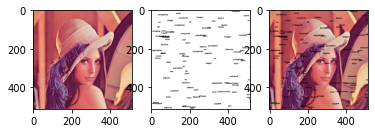

In [0]:
#converting the PIL Image into an ndarray
image_np = np.array(image).astype(np.float32) / 255.

#getting the text mask for the image
# args:
## image : PIL Image of test image loaded
## noise_type : 1 = Text, 2 = Bernoulli Noise
image_mask_np = get_mask(image,1)

f,ax = plot.subplots(ncols=3)
ax[0].imshow(image_np)
ax[1].imshow(image_mask_np)
ax[2].imshow(image_mask_np * image_np)

## 3. Setting up Network Params

In [0]:
# Params as described by paper
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 6001
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
    
net = SkipArchitecture(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,pad='reflection').type(dtype)
    

net = net.type(torch.cuda.FloatTensor)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(torch.cuda.FloatTensor)

In [0]:
# Parameters

s  = sum(np.prod(list(p.size())) for p in net.parameters())

NameError: ignored

In [0]:
# Define Loss function

error = torch.nn.MSELoss().type(torch.cuda.FloatTensor)

In [0]:
# Defining the image variables as pyTorch Tensors
image_t = torch.from_numpy(image_np)
image_mask_t = torch.from_numpy(image_mask_np)

## 4. Executing

In [0]:
 i = 0
 def closure():
   net_input = net_input_saved
   net_input = net_input_saved + (noise.normal_() * reg_noise_std)

   out = net(net_input)
   total_loss = mse(out * image_mask_t, image_t * image_mask_t)
   total_loss.backward()
   i += 1
   print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')

  # display images
   return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params('net', net, net_input)
optimize('adam', p, closure, LR, num_iter)

## 5. Display Result

In [0]:
image_tensor = net(net_input)
result_np = image_tensor.detach().cpu().numpy()[0]
plot.imshow(result_np)